In [1]:
import pathlib
import torch
import torchvision
import torchvision.models as models
from torchvision import datasets, transforms as T
from tqdm.notebook import tqdm_notebook
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
torch.cuda.get_device_name()

cuda:0


'NVIDIA GeForce GTX 1660 Ti with Max-Q Design'

In [3]:
RESNET_PATH_C = './resnet18_c.pth'
RESNET_PATH_C_aug = './resnet18_c_augm1.pth'

input_size = 244
batch_size = 32
num_classes = 10
log_dir = pathlib.Path.cwd() / "tensorboard_logs"
writer = SummaryWriter(log_dir)

In [4]:
transform = T.Compose([
    T.RandomAffine(degrees=(0,15), translate=(0.1, 0.3), scale=(0.75, 1.0)),
    T.RandomAdjustSharpness(sharpness_factor=2),
    T.RandomAutocontrast(),
    T.Resize(input_size),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
test_transform = T.Compose([
#     T.RandomAffine(degrees=(0,15), translate=(0.1, 0.3), scale=(0.75, 1.0)),
#     T.RandomAdjustSharpness(sharpness_factor=2),
#     T.RandomAutocontrast(),
    T.Resize(input_size),
    T.ToTensor(),
    T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

other_transform = T.Compose([
    T.Resize((input_size, input_size)),
    T.ToTensor(),
    T.Normalize(mean=0., std=1.)
])

# trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
#                                         download=True, transform=transform)
# # print('train + val:',trainset)
# trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
# # print('train set:',trainset.dataset)
# # print('val set:', valset.dataset)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)
# valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
#                                           shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


In [5]:
from raw_resnet import resnet18, ResNetBasicCustomBlock

resnet18_c = resnet18(3, 10,block=ResNetBasicCustomBlock)
resnet18_c = resnet18_c.to(device)
resnet18_c.load_state_dict(torch.load(RESNET_PATH_C_aug))

<All keys matched successfully>

In [6]:
# resnet18_c

In [7]:
model_weights = []
conv_layers = []

res_enc =  next(iter(resnet18_c.children()))
print('Encoder----\n\n')
#print(res_enc)
for layer2 in res_enc.children():
    
    #print('\t',layer2)
    if type(layer2) == nn.Sequential:
        print('\nSequiential layer---------\n\n')
        for layer3 in layer2.children():            
            if type(layer3) == nn.Conv2d:
                model_weights.append(layer3.weight)
                conv_layers.append(layer3)
                print('\t',layer3)
                print('-'*20+"This was conv layer"+'-'*20)
    else:
        print('\nmodule layer---------\n\n')
        # resnet_layers = next(iter(layer2.children()))
        # print(resnet_layers)
        for i, module_layers in enumerate(layer2.children()):
            print('\tchild3------------\n\n')
            print('MD-no:',i)
            # print(module_layers)
            seq = next(iter(module_layers.children()))
            for basic_block in seq.children():
                # print('\n\nshould be basic block\n')
                # print(basic_block)
                seq2 = next(iter(basic_block.children()))
                for seq3 in seq2.children():
                    # print('\n\n Should be 2 seq, dpot, etc\n\n')
                    # print(seq3)
                    if type(seq3) == nn.Sequential:
                        cnv = next(iter(seq3.children()))
                        print('Should be conv layer',cnv)
                        model_weights.append(cnv.weight)
                        conv_layers.append(cnv)
                        print('-'*20+"This was conv layer"+'-'*20)
                                
#             if type(module_layers) == nn.Conv2d:
#                 model_weights.append(layer3.weight)
#                 conv_layers.append(layer3)
#                 print('-'*20+"This was conv layer"+'-'*20)
            

print('Count of conv layers', len(conv_layers))

Encoder----



Sequiential layer---------


	 Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
--------------------This was conv layer--------------------

module layer---------


	child3------------


MD-no: 0
Should be conv layer Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
--------------------This was conv layer--------------------
Should be conv layer Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
--------------------This was conv layer--------------------
Should be conv layer Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
--------------------This was conv layer--------------------
Should be conv layer Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
--------------------This was conv layer--------------------
	child3------------


MD-no: 1
Should be conv layer Conv2dAuto(64, 128, kernel_size=(3, 3), stride=(2, 2), pa

In [8]:
# # we will save the conv layer weights in this list

# model_weights =[]
# #we will save the 49 conv layers in this list
# conv_layers = []# get all the model children as list
# model_children = list(resnet18_c.children())#counter to keep count of the conv layers
# counter = 0#append all the conv layers and their respective wights to the list
# for i in range(len(model_children)):
#     if type(model_children[i]) == nn.Conv2d:
#         counter+=1
#         model_weights.append(model_children[i].weight)
#         conv_layers.append(model_children[i])
#     elif type(model_children[i]) == nn.Sequential:
#         for j in range(len(model_children[i])):
#             for child in model_children[i][j].children():
#                 if type(child) == nn.Conv2d:
#                     counter+=1
#                     model_weights.append(child.weight)
#                     conv_layers.append(child)
# print(f"Total convolution layers: {counter}")
# print(conv_layers)

(237, 235)
Image shape before: torch.Size([3, 244, 244])
Image shape after: torch.Size([1, 3, 244, 244])
17
torch.Size([1, 64, 122, 122])
torch.Size([1, 64, 122, 122])
torch.Size([1, 64, 122, 122])
torch.Size([1, 64, 122, 122])
torch.Size([1, 64, 122, 122])
torch.Size([1, 128, 61, 61])
torch.Size([1, 128, 61, 61])
torch.Size([1, 128, 61, 61])
torch.Size([1, 128, 61, 61])
torch.Size([1, 256, 31, 31])
torch.Size([1, 256, 31, 31])
torch.Size([1, 256, 31, 31])
torch.Size([1, 256, 31, 31])
torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 16, 16])
torch.Size([1, 512, 16, 16])
(122, 122)
(122, 122)
(122, 122)
(122, 122)
(122, 122)
(61, 61)
(61, 61)
(61, 61)
(61, 61)
(31, 31)
(31, 31)
(31, 31)
(31, 31)
(16, 16)
(16, 16)
(16, 16)
(16, 16)


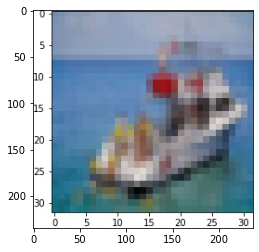

In [9]:
# Picking the image and passing thorough all the layers

from PIL import Image

image = Image.open(str('ship.jpg'))
plt.imshow(image)
print(image.size)
image= other_transform(image)
print(f"Image shape before: {image.shape}")
image = image.unsqueeze(0)
print(f"Image shape after: {image.shape}")
image = image.to(device)

outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)
    
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

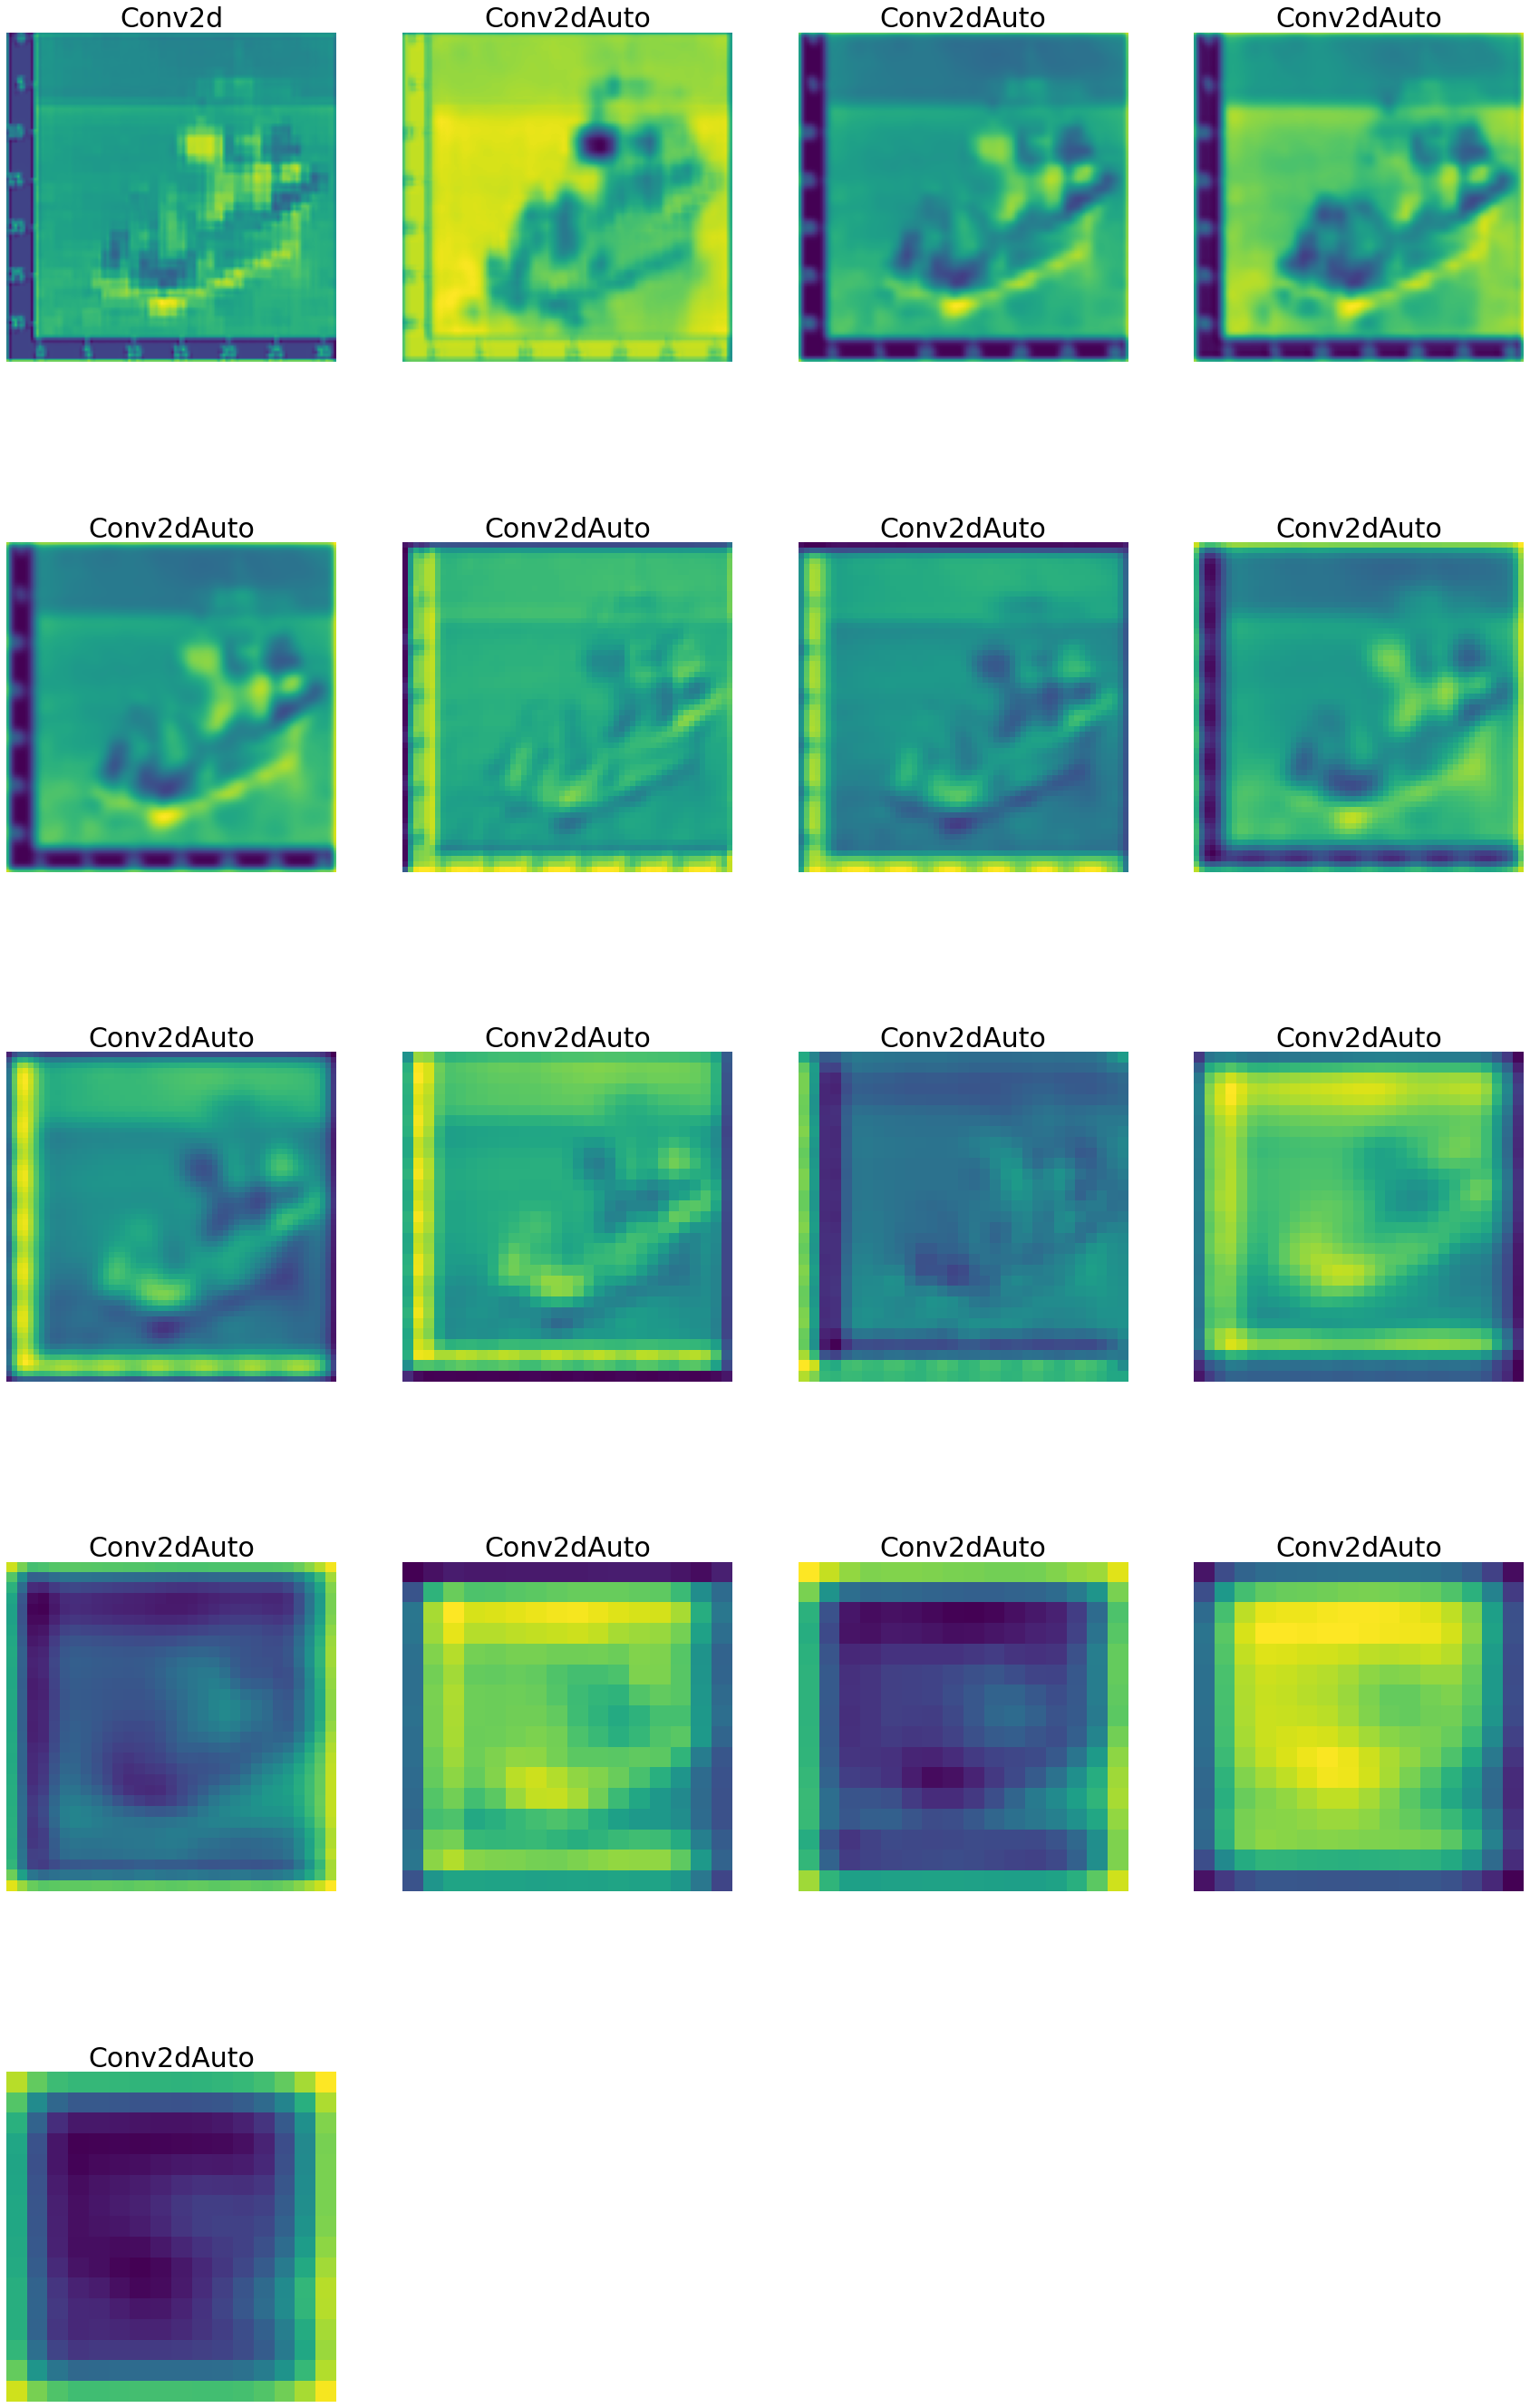

In [10]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('Part2_c_feature_maps.jpg'), bbox_inches='tight')